# <p style="font-family:newtimeroman;font-size:150%;text-align:center;">**Singapore Airlines Reviews** </p>

## **About the Dataset**

The "Singapore Airlines Reviews" dataset aggregates 10,000 anonymized customer reviews, providing a broad perspective on the passenger experience with Singapore Airlines. This extensive collection is instrumental for data-driven insights into customer satisfaction and service quality.
Data Science Applications:
Ideal for sentiment analysis, trend spotting, and predictive analytics, this dataset is a valuable asset for improving customer experience and operational efficiency.
Column Descriptors:

`published_date`: Date and time of review publication.

`published_platform`: Platform where the review was posted.

`rating`: Customer satisfaction rating, from 1 (lowest) to 5 (highest).

`type`: Specifies the content as a review.

`text`: Detailed customer feedback.

`title`: Summary of the review.

`helpful_votes`: Number of users finding the review helpful.

Ethical Considerations:
Compiled with a commitment to privacy, all personal identifiers have been removed to ensure ethical standards.


#### In this data sciense project we will perform the following:

1. Analyze Rating Distribution: Analyze the distribution of ratings to understand the overall satisfaction level of customers.

2. Trend Analysis: Look for trends in customer satisfaction over time by analyzing the published_date.
3. Platform Comparison: Compare customer satisfaction ratings and feedback across different published platforms to identify any discrepancies or patterns.   
4. Topic Modeling: Use natural language processing techniques to identify common topics or themes in the customer feedback.
5. Sentiment Analysis: Analyze the text of the reviews to determine the sentiment (positive, negative, neutral) of customers towards Singapore Airlines.



## **Import Libraries**

In [6]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
import string
import numpy as np 
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter


from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Set Matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [60]:
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix


## **Load the dataset**

In [11]:
path = 'singapore_airlines_reviews.csv'
df = pd.read_csv(path)
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


### Checking for columns name, data types, missing values and duplicates

In [12]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['Missing:np.nan'] = (df.isnull()).sum()
    summary_df['Missing:None'] = (df == "None").sum()
    summary_df['total'] =  summary_df['Missing:np.nan'] + summary_df['Missing:None']
    summary_df['Percent'] = 100*summary_df['total']/len(df)
    summary_df['Duplicates'] = df.duplicated().sum()
    summary_df['Unique'] = df.nunique().values
    summary_df['Count'] = df.count().values
    return summary_df.sort_values(ascending = False, by = 'Percent')

summary(df).style.background_gradient(cmap='Oranges')

,dtypes,Missing:np.nan,Missing:None,total,Percent,Duplicates,Unique,Count
title,object,1,0,1,0.010000,0,8476,9999
published_date,object,0,0,0,0.000000,0,9997,10000
published_platform,object,0,0,0,0.000000,0,2,10000
rating,int64,0,0,0,0.000000,0,5,10000
type,object,0,0,0,0.000000,0,1,10000
text,object,0,0,0,0.000000,0,10000,10000
helpful_votes,int64,0,0,0,0.000000,0,27,10000


In [13]:
df.dropna(inplace = True)

## **Data Preprocessing**

### Data cleaning
* Removing url, emoji, html, punctuations, numbers and lowercasing

In [14]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

In [15]:
df['Clean_text'] = df['text'].apply(clean_text)
df['Clean_title'] = df['title'].apply(clean_text)

### Removing Stopwords

In [16]:
stop_words = stopwords.words('english')
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['Clean_text'] = df['Clean_text'].apply(remove_stopwords)
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,Clean_text,Clean_title
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,used airline go singapore london heathrow. iss...,ok
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,service singapore airlines suites class nothin...,the service in suites class makes one feel lik...
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,"booked, paid received email confirmation extra...",don’t give them your money
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,"best airline world, seats, food, service brill...",best airline in the world
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,premium economy seating singapore airlines nar...,premium economy seating on singapore airlines ...


### Stemming

In [18]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [19]:
df['Clean_text'] = df['Clean_text'].apply(stemm_text)
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,Clean_text,Clean_title
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,use airlin go singapor london heathrow. issu t...,ok
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,servic singapor airlin suit class noth excelle...,the service in suites class makes one feel lik...
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,"booked, paid receiv email confirm extra legroo...",don’t give them your money
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,"best airlin world, seats, food, servic brillia...",best airline in the world
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,premium economi seat singapor airlin narrow se...,premium economy seating on singapore airlines ...


### Text Visualization

## **Rating Distribution**

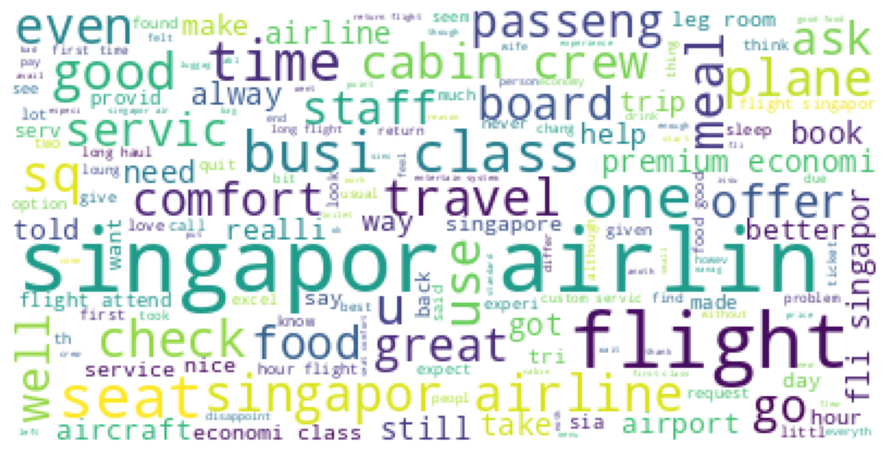

In [20]:
all_text = " ".join(df['Clean_text'])
wc = WordCloud(background_color='white').generate(all_text)

plt.figure(figsize = (9,6))
plt.imshow(wc)
plt.axis('off')
plt.show()

Text(0.5, 0, 'Rating')

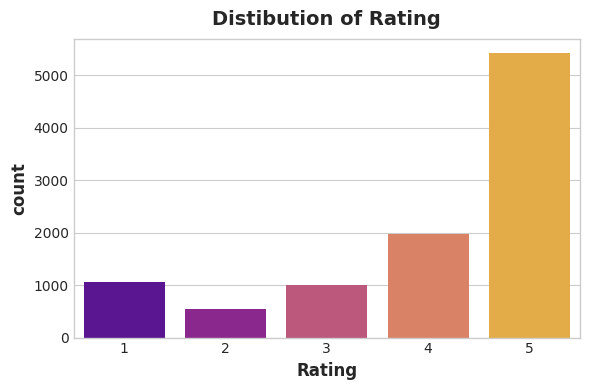

In [21]:
fig = plt.figure(figsize=(6,4), dpi=100)
ax = fig.gca()
sns.countplot(x=df['rating'], data=df, palette ='plasma')
ax.set_title("Distibution of Rating")
ax.set_xlabel("Rating")

## **Trend Analysis**

In [22]:
# Convert 'published_date' to datetime format with UTC "Coordinated Unuversal Time"
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce', utc=True)

# Check if the conversion was successful
if df['published_date'].dtype == 'datetime64[ns, UTC]':
    df['year'] = df['published_date'].dt.year
    df['month'] = df['published_date'].dt.month
    df['day'] = df['published_date'].dt.day
    # Other datetime related operations...
else:
    print("Conversion to datetime format unsuccessful")

In [23]:
trend = df[['published_date','rating']]
trend = trend.set_index('published_date')

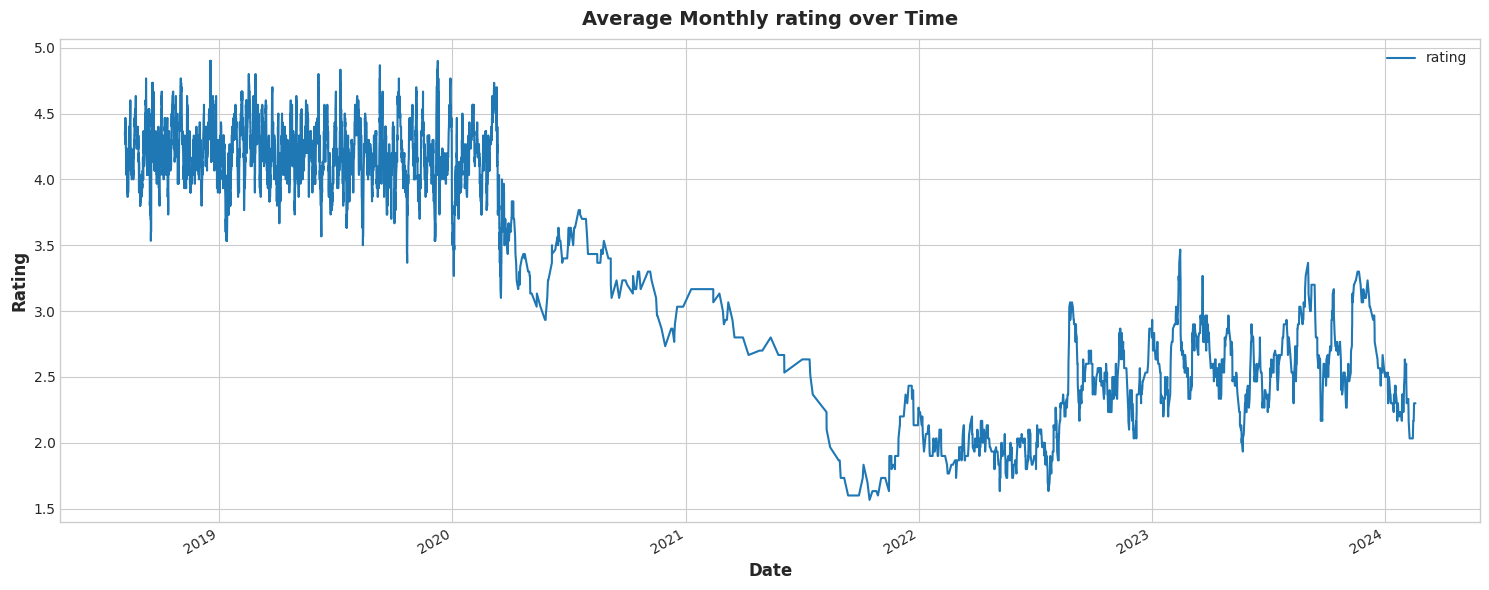

In [24]:
fig, ax = plt.subplots(figsize=(15,6))
trend.rolling(30).mean().plot(xlabel="Date", ylabel="Rating", title='Average Monthly rating over Time', ax=ax);

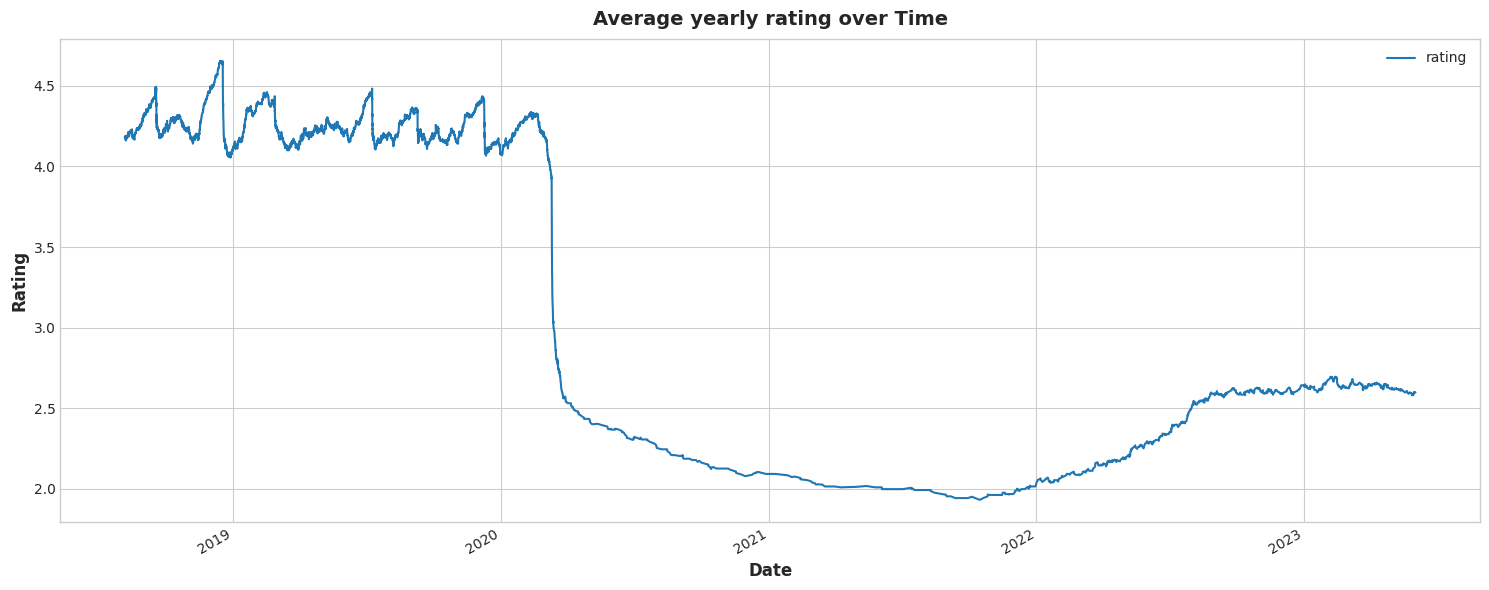

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
trend.rolling(360).mean().plot(xlabel="Date", ylabel="Rating", title='Average yearly rating over Time', ax=ax);

## **Platform Comparison**

In [26]:
# reviews counts across plat forms
df['published_platform'].value_counts()

published_platform
Desktop    7351
Mobile     2648
Name: count, dtype: int64

In [27]:
## rating median across plat forms
medians = df.groupby('published_platform')['rating'].median()
medians

published_platform
Desktop    5.0
Mobile     5.0
Name: rating, dtype: float64

In [28]:
## rating mean across plat forms
means = df.groupby('published_platform')['rating'].mean()
means

published_platform
Desktop    3.964359
Mobile     4.159366
Name: rating, dtype: float64

Text(0.5, 1.0, 'Distribution of reviews across the platforms')

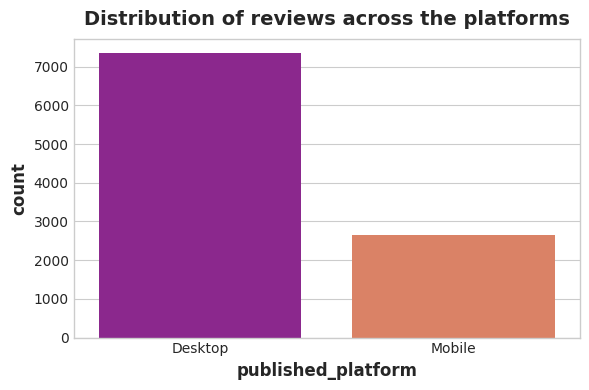

In [32]:
plt.figure(figsize=(6,4), dpi=100)
sns.countplot(x='published_platform', data=df, palette ='plasma')
plt.title('Distribution of reviews across the platforms')

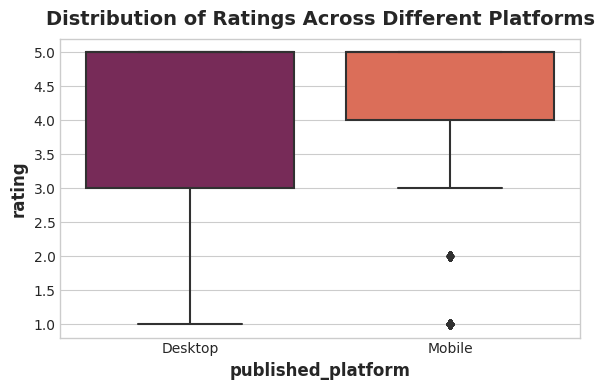

In [31]:
plt.figure(figsize=(6,4), dpi=100)
sns.boxplot( x='published_platform', y='rating', data = df,  palette='rocket')
plt.title('Distribution of Ratings Across Different Platforms')
plt.tight_layout()
plt.show()

In [33]:
''' To compare customers satisfaction across platforms, 
we can calculate the overall satisfaction score for each platform by calculating 
a wieghted average satisfaction score as it  take into account both the number of reviews and the average rating'''
desktop_count = 7351
mobile_count = 2648
desktop_avg = 3.96
mobile_avg = 4.15
overall_satisfaction_desktop = desktop_count*desktop_avg
overall_satisfaction__mobile = mobile_count*mobile_avg
# compare customer satisfaction
if overall_satisfaction_desktop > overall_satisfaction__mobile:
    print("Customers using desktop platform are more satisfyed")
elif overall_satisfaction_desktop < overall_satisfaction__mobile:
    print("Customers using mobile platform are more satisfyed")
else:
    print("Customers using desktop platform and mobile platform have the same level of satisfaction")

Customers using desktop platform are more satisfyed


## Sentiment analysis

In [34]:
# create a new column 'sentiment_score' that contain sentiment scores of each review based on the polarity of the text
df['sentiment_score'] = df['Clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [35]:
## Categorize reviews into positive, negative and neutral based on thier sentiment score
'''define a function to map sentiments scores to categories with a threshold of 0.2 and -0.2 that is,
        a sentiments score > 0.2 will be considered positive, < -0.2 will be considered negative, otherwise  will be considered neutral '''
def sentiment(score):
    if score > 0.2:
        return "positive"
    elif score < -0.2:
        return "negative"
    else:
        return "neutral"
# creat a new column "sentiment"
df['sentiment'] = df['sentiment_score'].apply(sentiment)

In [36]:
# Create a new column 'Label' to store the labled sentiment
df['label'], _ = pd.factorize(df['sentiment'])

In [37]:
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,Clean_text,Clean_title,year,month,day,sentiment_score,sentiment,label
0,2024-03-12 18:41:14+00:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,use airlin go singapor london heathrow. issu t...,ok,2024,3,12,0.177803,neutral,0
1,2024-03-11 23:39:13+00:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,servic singapor airlin suit class noth excelle...,the service in suites class makes one feel lik...,2024,3,11,0.195060,neutral,0
2,2024-03-11 16:20:23+00:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,"booked, paid receiv email confirm extra legroo...",don’t give them your money,2024,3,11,-0.132500,neutral,0
3,2024-03-11 11:12:27+00:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,"best airlin world, seats, food, servic brillia...",best airline in the world,2024,3,11,0.800000,positive,1
4,2024-03-10 09:34:18+00:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,premium economi seat singapor airlin narrow se...,premium economy seating on singapore airlines ...,2024,3,10,-0.250505,negative,2


### Train-Test Split

In [38]:
SEED = 42
from sklearn.model_selection import train_test_split

X = df['Clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = SEED, 
                                                    stratify = y)

X_train.shape, X_test.shape

((6999,), (3000,))

### Tokenization

In [41]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [42]:
# Max Len in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 1200


In [45]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post',)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[ 311   48    2 ...    0    0    0]
 [2299    1  104 ...    0    0    0]
 [  70  316    2 ...    0    0    0]
 ...
 [   3 1090  117 ...    0    0    0]
 [  70    2 5197 ...    0    0    0]
 [ 131   10    2 ...    0    0    0]]

X_test_padded:
[[ 29 653  10 ...   0   0   0]
 [  8  96   2 ...   0   0   0]
 [ 34   1 137 ...   0   0   0]
 ...
 [  1  23  12 ...   0   0   0]
 [ 29 214  18 ...   0   0   0]
 [ 18   2   3 ...   0   0   0]]


In [52]:
# Embedding Input Size / Vocabulary Size 
input_Size = np.max(X_train_padded) + 1
input_Size

14868

In [71]:
# Define the model
model = Sequential()

# Add an embedding layer 
model.add(Embedding(input_dim = input_Size, output_dim=100,input_shape=(1200,)))

# Add a bidirectional LSTM layer with 128 units
model.add(Bidirectional(LSTM(128)))

# Add batch normalization layer
model.add(BatchNormalization())

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 6 units for 6 labels and softmax activation
model.add(Dense(6, activation='softmax'))

In [72]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 1200, 100)      │     1,486,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,739,158 (6.63 MB)

 Trainable params: 1,738,646 (6.63 MB)

 Non-trainable params: 512 (2.00 KB)

In [73]:
# Model Train 
history = model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 597s 3s/step - accuracy: 0.5564 - loss: 1.1260 - val_accuracy: 0.5917 - val_loss: 1.3604
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 590s 3s/step - accuracy: 0.8140 - loss: 0.4755 - val_accuracy: 0.5533 - val_loss: 0.7834
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.9029 - loss: 0.2770 - val_accuracy: 0.7033 - val_loss: 0.9098
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 621s 3s/step - accuracy: 0.9330 - loss: 0.1968 - val_accuracy: 0.5050 - val_loss: 2.2188
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 622s 3s/step - accuracy: 0.9432 - loss: 0.1568 - val_accuracy: 0.7077 - val_loss: 1.5374


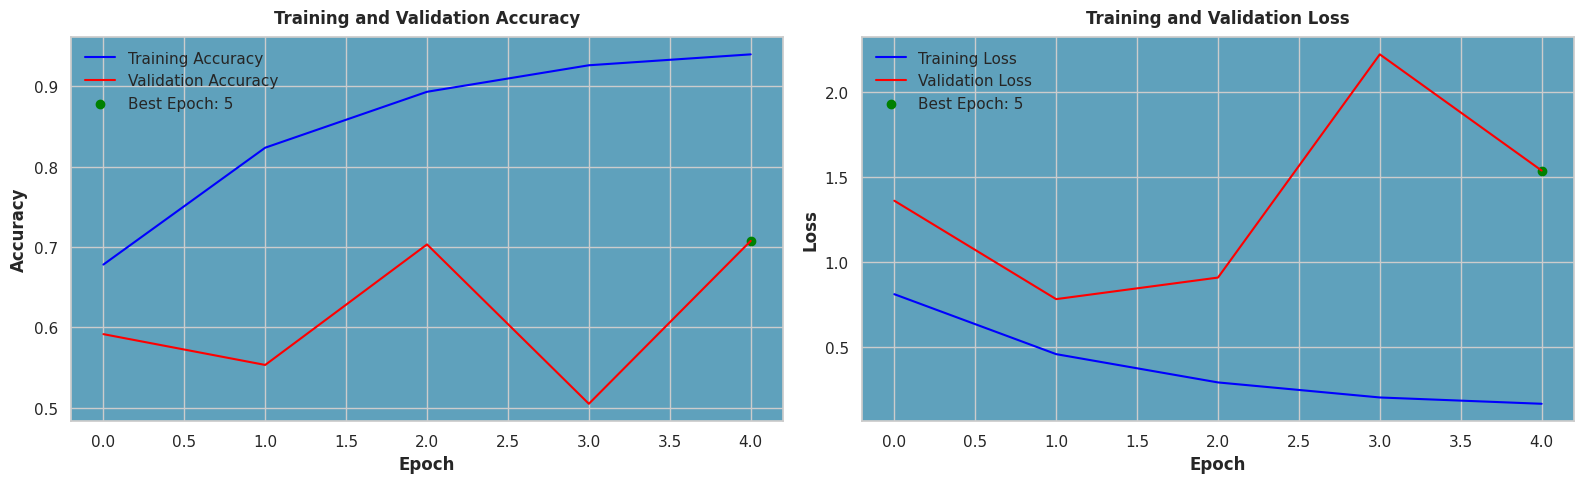

In [74]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()


# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

## **Topic Modeling**

In [65]:
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

x_train_bow = count_vectorizer.fit_transform(X_train)
x_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [66]:
lda = LatentDirichletAllocation(n_components=5)  # Adjust the number of topics as needed
lda.fit_transform(x_train_tfidf)

array([[0.03013379, 0.02977069, 0.8805564 , 0.02976982, 0.0297693 ],
       [0.03842558, 0.03762564, 0.78295018, 0.0376241 , 0.1033745 ],
       [0.0176678 , 0.01746337, 0.92994516, 0.01746219, 0.01746149],
       ...,
       [0.61430035, 0.03534622, 0.27957127, 0.03534593, 0.03543623],
       [0.02495716, 0.024773  , 0.90072191, 0.02477543, 0.0247725 ],
       [0.0372817 , 0.03683716, 0.85220714, 0.03683709, 0.03683692]])

In [67]:
feature_names = tfidf_vectorizer.get_feature_names_out()

In [68]:
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    top_words_idx = topic.argsort()[:-10:-1]  # Get indices of top 10 words for each topic
    top_words = [feature_names[i] for i in top_words_idx]
    print(top_words)


Topic 0:
['good', 'great', 'food', 'flight', 'staff', 'servic', 'singapor', 'airlin', 'excel']
Topic 1:
['supportive', 'appropriate', 'shortcom', 'approachable', 'milano', 'stil', 'confi', 'std', 'economic']
Topic 2:
['flight', 'singapor', 'airlin', 'seat', 'good', 'food', 'servic', 'time', 'class']
Topic 3:
['bom', 'fss', 'favorites', 'siem', 'gin', 'chardonnay', 'recomend', 'ppl', 'aid']
Topic 4:
['chi', 'stockholm', 'cordial', 'ho', 'dhaka', 'minh', 'slings', 'tuesday', 'oldest']
